## AutoML Assignment - Sanket Sanap
### Bank Loan Status Classification



In [2]:
# Import libraries
# Use pip install or conda install if missing a library
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2ORandomForestEstimator
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
from scipy.stats import linregress
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [3]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6
run_time=360

In [4]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

0


In [5]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:35075 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_311"; Java(TM) SE Runtime Environment (build 1.8.0_311-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from /opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5q/w_y2sfjj2bv130sh86slry7r0000gq/T/tmp1fzhkra0
  JVM stdout: /var/folders/5q/w_y2sfjj2bv130sh86slry7r0000gq/T/tmp1fzhkra0/h2o_work_started_from_python.out
  JVM stderr: /var/folders/5q/w_y2sfjj2bv130sh86slry7r0000gq/T/tmp1fzhkra0/h2o_work_started_from_python.err
  Server is running at http://127.0.0.1:35075
Connecting to H2O server at http://127.0.0.1:35075 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_work_g16u3m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Import Bank Loan Status Dataset

Importing csv dataset from GitHub

In [6]:

url = "https://raw.githubusercontent.com/sanapsanket/Bank-Loan-Status-Predictive-Analysis/main/KaggleDataset/BankLoanStatusDataset/credit_train.csv"
og_df = h2o.import_file(path = url)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [56]:
og_pdf = pd.read_csv("https://raw.githubusercontent.com/sanapsanket/Bank-Loan-Status-Predictive-Analysis/main/KaggleDataset/BankLoanStatusDataset/credit_train.csv")


### Handling Missing / Null Values
Handling missing, null data by removing row for now

In [68]:
og_df=og_df.na_omit()
og_pdf = og_pdf.dropna()
og_pdf.rename(columns = {'Loan Status':'Loan_Status'}, inplace = True)
og_pdf.rename(columns = {'Current Loan Amount':'Current_Loan_Amount'}, inplace = True)
og_pdf.rename(columns = {'Credit Score':'Credit_Score'}, inplace = True)
og_pdf.rename(columns = {'Annual Income':'Annual_Income'}, inplace = True)
og_pdf.rename(columns = {'Years in current job':'Years_in_currentjob'}, inplace = True)
og_pdf.rename(columns = {'Home Ownership':'Home_Ownership'}, inplace = True)
og_pdf.rename(columns = {'Monthly Debt':'Monthly_Debt'}, inplace = True)
og_pdf.rename(columns = {'Years of Credit History':'Years_of_Credit_History'}, inplace = True)
og_pdf.rename(columns = {'Months since last delinquent':'Months_since_last_delinquent'}, inplace = True)
og_pdf.rename(columns = {'Number of Open Accounts':'Number_of_Open_Accounts'}, inplace = True)
og_pdf.rename(columns = {'Current Credit Balance':'Current_Credit_Balance'}, inplace = True)
og_pdf.rename(columns = {'Maximum Open Credit':'Maximum_Open_Credit'}, inplace = True)
df = og_df
pdf = og_pdf
df.head(1)


Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
4EED4E6A-AA2F-4C91-8651-CE984EE8FB26,5EFB2B2B-BF11-4DFD-A572-3761A2694725,Fully Paid,1e+08,Short Term,741,2.23189e+06,8 years,Own Home,Debt Consolidation,29200.5,14.9,29,18,1,297996,750090,0,0


### Dropping Constant Columns Loan ID & Customer ID

In [45]:
#df.describe()
df=df.drop('Loan ID')
df=df.drop('Customer ID')
print("Done")

Done


### Splitting Into Training, Testing frames
Splitting into 80-20% for training-testing frames respectively

In [46]:
# Create a 80/20 train/test splie
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])
print(df_train.shape)
print(df_test.shape)

(30490, 17)
(7520, 17)


### Setting Features and Target variables

In [143]:
# Set target and predictor variables
X=df.columns
target ='Loan Status'
X.remove(target)
df_train[target]=df_train[target].asfactor()
df_test[target]=df_test[target].asfactor()
print(X)

['Current Loan Amount', 'Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens']


### Setting Up AutoML
Excluding StackedEnsemble and DeepLearning algorithms as these often provides better accuracy and performance metrics

However, they are more complex and harder to interpret.
Setting other parameters for H2oAutoML

In [144]:
# Set up AutoML
exclude_algos = ["StackedEnsemble","DeepLearning"]
aml = H2OAutoML(seed=1,max_runtime_secs=run_time, exclude_algos=exclude_algos)


### Training AutoML

In [145]:
weights_column = "Credit Score"
validation_frame = df_test
aml.train(x=X,y=target,training_frame=df_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_3_20220213_11657


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,1350863.0,20.0,20.0,20.0,1660.0,2514.0,2141.38




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11680126956983737
RMSE: 0.3417620072065316
LogLoss: 0.37232274281184635
Mean Per-Class Error: 0.37076630074316186
AUC: 0.8043193209175095
AUCPR: 0.9358105208013514
Gini: 0.6086386418350189

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21152517530653214: 


,,Charged Off,Fully Paid,Error,Rate
0,Charged Off,1633.0,4684.0,0.7415,(4684.0/6317.0)
1,Fully Paid,1.0,24161.0,0.0,(1.0/24162.0)
2,Total,1634.0,28845.0,0.1537,(4685.0/30479.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.211525,0.911615,371.0
1,max f2,0.176471,0.962660,373.0
2,max f0point5,0.721204,0.876028,224.0
3,max accuracy,0.434654,0.846452,349.0
4,max precision,0.996017,0.999473,2.0
5,max recall,0.176471,1.000000,373.0
6,max specificity,0.999996,0.999683,0.0
7,max absolute_mcc,0.211525,0.465121,371.0
8,max min_per_class_accuracy,0.811106,0.710939,154.0
9,max mean_per_class_accuracy,0.793974,0.716130,169.0



Gains/Lift Table: Avg response rate: 79.27 %, avg score: 79.77 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.120936,1.000000,1.260759,1.260759,0.999457,1.000000,0.999457,1.000000,0.152471,0.152471,26.075914,26.075914,0.152154
1,2,0.150005,0.969146,1.213036,1.251511,0.961625,0.983698,0.992126,0.996841,0.035262,0.187733,21.303605,25.151096,0.182034
2,3,0.200007,0.943458,1.179499,1.233508,0.935039,0.954706,0.977854,0.986307,0.058977,0.246710,17.949942,23.350808,0.225339
3,4,0.300010,0.909132,1.155909,1.207642,0.916339,0.925351,0.957349,0.965988,0.115595,0.362304,15.590943,20.764186,0.300566
4,5,0.400013,0.880212,1.124042,1.186742,0.891076,0.894519,0.940781,0.948121,0.112408,0.474712,12.404225,18.674196,0.360418
5,6,0.500016,0.851914,1.090106,1.167415,0.864173,0.866330,0.925459,0.931763,0.109014,0.583727,9.010578,16.741472,0.403894
6,7,0.599987,0.819597,1.035816,1.145488,0.821136,0.836058,0.908077,0.915816,0.103551,0.687278,3.581617,14.548763,0.421170
7,8,0.699990,0.780561,1.010645,1.126223,0.801181,0.800860,0.892805,0.899393,0.101068,0.788345,1.064477,12.622346,0.426306
8,9,0.799993,0.723679,0.936978,1.102567,0.742782,0.754475,0.874052,0.881278,0.093701,0.882046,-6.302222,10.256678,0.395898
9,10,0.899997,0.609825,0.833513,1.072671,0.660761,0.675640,0.850352,0.858428,0.083354,0.965400,-16.648708,7.267082,0.315566




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.11670854016387107
RMSE: 0.341626316556367
LogLoss: 0.36878925599315304
Mean Per-Class Error: 0.3702536275737946
AUC: 0.8069309992493416
AUCPR: 0.9378548742532158
Gini: 0.6138619984986833

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3890881009896596: 


,,Charged Off,Fully Paid,Error,Rate
0,Charged Off,1640.0,4677.0,0.7404,(4677.0/6317.0)
1,Fully Paid,3.0,24159.0,0.0001,(3.0/24162.0)
2,Total,1643.0,28836.0,0.1535,(4680.0/30479.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.389088,0.911695,377.0
1,max f2,0.323208,0.962676,382.0
2,max f0point5,0.743505,0.874102,226.0
3,max accuracy,0.389088,0.846452,377.0
4,max precision,0.999992,1.000000,0.0
5,max recall,0.323208,1.000000,382.0
6,max specificity,0.999992,1.000000,0.0
7,max absolute_mcc,0.389088,0.465759,377.0
8,max min_per_class_accuracy,0.805757,0.717407,169.0
9,max mean_per_class_accuracy,0.807345,0.719371,167.0



Gains/Lift Table: Avg response rate: 79.27 %, avg score: 79.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.096788,1.000000,1.261444,1.261444,1.000000,1.000000,1.000000,1.000000,0.122093,0.122093,26.144359,26.144359,0.122093
1,2,0.100135,0.998630,1.261444,1.261444,1.000000,0.999215,1.000000,0.999974,0.004222,0.126314,26.144359,26.144359,0.126314
2,3,0.150005,0.953701,1.253145,1.258685,0.993421,0.976361,0.997813,0.992124,0.062495,0.188809,25.314462,25.868453,0.187226
3,4,0.200007,0.925596,1.183638,1.239923,0.938320,0.937769,0.982940,0.978535,0.059184,0.247993,18.363801,23.992290,0.231529
4,5,0.300010,0.893820,1.159634,1.213160,0.919291,0.908812,0.961724,0.955294,0.115967,0.363960,15.963417,21.315999,0.308554
5,6,0.400013,0.868330,1.130664,1.192536,0.896325,0.880854,0.945374,0.936684,0.113070,0.477030,13.066400,19.253599,0.371600
6,7,0.500049,0.843091,1.078578,1.169738,0.855034,0.855528,0.927301,0.920449,0.107897,0.584927,7.857771,16.973835,0.409527
7,8,0.599987,0.813693,1.056449,1.150868,0.837492,0.828851,0.912342,0.905191,0.105579,0.690506,5.644865,15.086809,0.436746
8,9,0.699990,0.779192,0.971328,1.125218,0.770013,0.797229,0.892008,0.889768,0.097136,0.787642,-2.867188,12.521832,0.422912
9,10,0.799993,0.730128,0.919596,1.099514,0.729003,0.756100,0.871632,0.873058,0.091963,0.879604,-8.040431,9.951444,0.384116




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.846812,0.002333,0.844324,0.845800,0.848589,0.849902,0.845447
1,auc,0.806924,0.003644,0.809226,0.806962,0.805706,0.811143,0.801581
2,err,0.153187,0.002333,0.155676,0.154199,0.151411,0.150098,0.154553
3,err_count,933.800000,14.202112,949.000000,940.000000,923.000000,915.000000,942.000000
4,f0point5,0.866246,0.002092,0.863679,0.865340,0.867840,0.868888,0.865484
5,f1,0.911859,0.001445,0.910209,0.911103,0.912834,0.913817,0.911333
6,f2,0.962544,0.000688,0.962038,0.961976,0.962749,0.963647,0.962311
7,lift_top_group,1.261456,0.004389,1.267360,1.264468,1.260285,1.256648,1.258517
8,logloss,0.368789,0.004080,0.371496,0.370264,0.367616,0.362227,0.372344
9,max_per_class_error,0.737550,0.007939,0.737947,0.734118,0.729944,0.734940,0.750799



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-02-13 01:18:53,25.308 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-02-13 01:18:53,25.676 sec,5.0,0.394597,2.542492,0.716288,0.879878,1.125212,0.165634
2,,2022-02-13 01:18:53,25.894 sec,10.0,0.369916,1.176203,0.746303,0.899006,1.170143,0.157917
3,,2022-02-13 01:18:54,26.192 sec,15.0,0.357063,0.670127,0.766634,0.914112,1.214385,0.155425
4,,2022-02-13 01:18:54,26.587 sec,20.0,0.351249,0.497584,0.778434,0.922245,1.238315,0.154444
5,,2022-02-13 01:18:54,26.995 sec,25.0,0.347940,0.425272,0.785726,0.927035,1.251132,0.154106
6,,2022-02-13 01:18:55,27.343 sec,30.0,0.345361,0.398444,0.791909,0.930135,1.256292,0.153712
7,,2022-02-13 01:18:55,27.680 sec,35.0,0.343910,0.388393,0.797010,0.932401,1.257953,0.153548
8,,2022-02-13 01:18:55,27.906 sec,40.0,0.343051,0.379792,0.799905,0.933783,1.259477,0.153712
9,,2022-02-13 01:18:56,28.212 sec,45.0,0.342363,0.375805,0.802439,0.934977,1.260104,0.153712



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Credit Score,44759.878906,1.000000,0.369561
1,Current Loan Amount,12418.345703,0.277444,0.102532
2,Years in current job,8296.091797,0.185347,0.068497
3,Annual Income,7722.340332,0.172528,0.063760
4,Years of Credit History,7420.987793,0.165796,0.061272
5,Months since last delinquent,7333.394043,0.163839,0.060548
6,Monthly Debt,7235.675293,0.161655,0.059741
7,Number of Open Accounts,6172.034180,0.137892,0.050960
8,Current Credit Balance,5495.642090,0.122781,0.045375
9,Purpose,4258.420410,0.095139,0.035160


### Leaderboard Statistics
This chart will show accuracy metrics for differnet models used with different hyperparameter in the order of `High-Low` accuracy performance

As we can see for this dataset, **`DRF`** (Distributed Random Forest) model is the most accurate model among other model shown in AutoML leaderboard. As, AUC (Area Under Curve) is highest (**0.806**) and MSE (**0.116**), RMSE (**0.341**) are loweset among all other model shown in leaderboard above.

In [147]:
print(aml.leaderboard)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DRF_1_AutoML_3_20220213_11657,0.806931,0.368789,0.937855,0.370254,0.341626,0.116709
XRT_1_AutoML_3_20220213_11657,0.797923,0.372053,0.934581,0.370274,0.34285,0.117546
GBM_4_AutoML_3_20220213_11657,0.782528,0.379964,0.928098,0.366618,0.345816,0.119589
GBM_2_AutoML_3_20220213_11657,0.781311,0.379607,0.927816,0.370825,0.345857,0.119617
GBM_3_AutoML_3_20220213_11657,0.780783,0.379918,0.927546,0.367537,0.345963,0.119691
GBM_1_AutoML_3_20220213_11657,0.780411,0.380156,0.927727,0.369345,0.346036,0.119741
GBM_grid_1_AutoML_3_20220213_11657_model_2,0.779695,0.380465,0.927251,0.369236,0.346018,0.119728
GBM_5_AutoML_3_20220213_11657,0.77966,0.379759,0.927398,0.369682,0.345757,0.119548
GBM_grid_1_AutoML_3_20220213_11657_model_1,0.778459,0.394003,0.926428,0.369673,0.349624,0.122237
XGBoost_3_AutoML_3_20220213_11657,0.776441,0.380431,0.926294,0.370825,0.347021,0.120424


In [148]:
best = aml.get_best_model()
best.accuracy()

[[0.43465394368851945, 0.8464516552380328]]

In [57]:
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass
    try:
      d['gini']=perf.gini()
    except:
      pass 
    return d

In [150]:
mod_perf=best.model_performance(df_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 0.11438375424067015,
 'rmse': 0.3382066738558986,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None,
 'logloss': 0.3634367523650762,
 'auc': 0.8141908689530367,
 'gini': 0.6283817379060734}

In [151]:
predictions = best.predict(df_test)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [152]:
y_pred=h2o.as_list(predictions)
y_pred[:5]

,predict,Charged Off,Fully Paid
0,Fully Paid,0.002353,0.997647
1,Fully Paid,0.000000,1.000000
2,Fully Paid,0.175109,0.824891
3,Charged Off,1.000000,0.000000
4,Fully Paid,0.093663,0.906337


### Correlation Metrics

In [396]:
# df_col = pdf[['Loan Status','Current Loan Amount','Term','Credit Score','Annual Income','Years in current job','Home Ownership','Purpose','Monthly Debt','Years of Credit History','Months since last delinquent','Number of Open Accounts','Number of Credit Problems','Current Credit Balance','Maximum Open Credit','Bankruptcies','Tax Liens']]

# sns.pairplot(df_col, kind="scatter")
# plt.show()

# pdf.corr()

## Is Relationship Significant ?
To identify how important a particular feature for the model, I will be using variable importance statistcs

As we can see in variable importance statistics metrics, **`scaled_importance`** shows how important particular feature / variable is, in range of **0-1**, where value closer to **1** means highly important and value closer to **0** meand less important

>    best.varimp(use_pandas=True)
    
We can clearly see that `Credit Score` is the highly important feature along with `Current Loan Amount` `Annual Income` `Years in current job` etc are important with 12% - 27% importance which make sense considering domain knowledge

There are few features, specifically at the end of table which have less importance less than 10% like `Purpose` `Tax Liens` `Term` etc. These feature may be removed from traing and we can observe if there is any increase/ decrease in accuracy metrics in later stage of this notebook

In [153]:
best.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,Credit Score,44759.878906,1.000000,0.369561
1,Current Loan Amount,12418.345703,0.277444,0.102532
2,Years in current job,8296.091797,0.185347,0.068497
3,Annual Income,7722.340332,0.172528,0.063760
4,Years of Credit History,7420.987793,0.165796,0.061272
5,Months since last delinquent,7333.394043,0.163839,0.060548
6,Monthly Debt,7235.675293,0.161655,0.059741
7,Number of Open Accounts,6172.034180,0.137892,0.050960
8,Current Credit Balance,5495.642090,0.122781,0.045375
9,Purpose,4258.420410,0.095139,0.035160


In [235]:

# print("Current Loan Amount: ",linregress(pdf['Current Loan Amount'],pdf['Credit Score']).pvalue)
# print("Annual Income: ",linregress(pdf['Annual Income'],pdf['Credit Score']).pvalue)
# print("Monthly Debt: ",linregress(pdf['Monthly Debt'],pdf['Credit Score']).pvalue)
# print("Years of Credit History: ",linregress(pdf['Years of Credit History'],pdf['Credit Score']).pvalue)
# print("Months since last delinquent: ",linregress(pdf['Months since last delinquent'],pdf['Credit Score']).pvalue)
# print("Number of Open Accounts: ",linregress(pdf['Number of Open Accounts'],pdf['Credit Score']).pvalue)
# print("Current Credit Balance: ",linregress(pdf['Current Credit Balance'],pdf['Credit Score']).pvalue)
# print("Maximum Open Credit: ",linregress(pdf['Maximum Open Credit'],pdf['Credit Score']).pvalue)
# print("Bankruptcies: ",linregress(pdf['Bankruptcies'],pdf['Credit Score']).pvalue)
# print("Tax Liens: ",linregress(pdf['Tax Liens'],pdf['Credit Score']).pvalue)

# stats.pearsonr(pdf['Credit Score'],pdf['Current Loan Amount'])

## Are any model assumptions violated ?


As we saw **`DRF`** (Distributed Random Forest) model is the most accurate model for this data set

For Random Forest assumptions are, 
* At each step while creating a individual tree best split of data is considered and splitting continued further
* Instead of whole data bootstrap sample data is used from the population
* Bagging is used

So, There seems **no** assumption violated as can be seen in below graphs as the number of trees increase the `classification_error`, `rmse`, `logloss` decreases and `AUC` increase significantly. Which would indicate that sample data representation did not affect the performance, accuracy of the model.


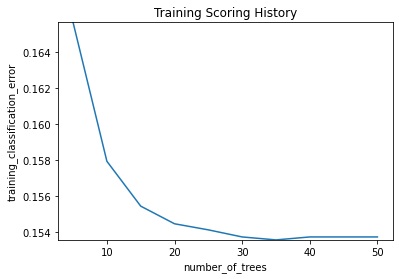

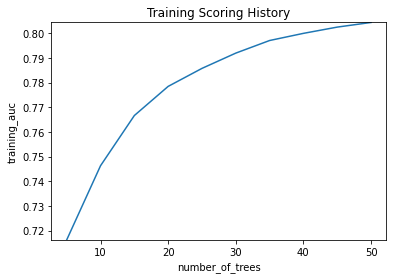

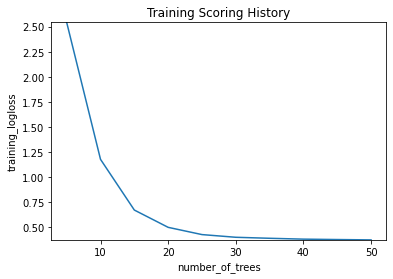

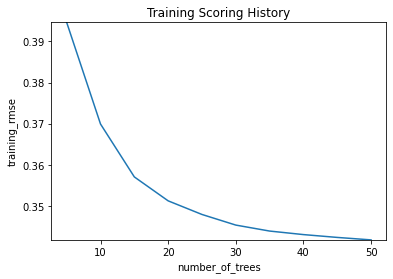

In [154]:
best.plot(metric='classification_error')
best.plot(metric='auc')
best.plot(metric='logloss')
best.plot(metric='rmse')


In [156]:
# best.explain(df_train)


In [395]:
#best.learning_curve_plot()

### Is there Multicollinearity in the model ?

As shown in below Correlation matrics, there is very low Multicollinearity i.e. indipendent variables are co-linear with each other. 

At threshold of 75% or 80% there is very less Multicollinearity, provided that `Number of Credit Problems` and `Bankruptcies` shows as 70%, `Monthly Debt` and `Annual Income` has 55%, `Current Credit Balance` and `Monthly Debt` has 44% etc.

In [157]:
pdf.corr()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Current Loan Amount,1.000000,-0.091345,0.014758,-0.003642,0.017056,0.012938,0.004405,-0.002140,0.009030,-0.000508,-0.002362,-0.003566
Credit Score,-0.091345,1.000000,-0.019661,0.008614,-0.011369,-0.003322,0.013045,-0.001187,-0.001974,-0.003887,-0.007259,0.009064
Annual Income,0.014758,-0.019661,1.000000,0.550253,0.174606,-0.076599,0.137217,-0.017161,0.351848,0.053694,-0.060960,0.058750
Monthly Debt,-0.003642,0.008614,0.550253,1.000000,0.176675,-0.058531,0.378374,-0.046957,0.445240,0.043217,-0.073098,0.029356
Years of Credit History,0.017056,-0.011369,0.174606,0.176675,1.000000,-0.043813,0.099213,0.020433,0.204668,0.029807,0.020519,0.008878
Months since last delinquent,0.012938,-0.003322,-0.076599,-0.058531,-0.043813,1.000000,-0.029901,0.103422,-0.026585,-0.006517,0.124807,0.012115
Number of Open Accounts,0.004405,0.013045,0.137217,0.378374,0.099213,-0.029901,1.000000,-0.014211,0.225738,0.032036,-0.019409,0.000633
Number of Credit Problems,-0.002140,-0.001187,-0.017161,-0.046957,0.020433,0.103422,-0.014211,1.000000,-0.111532,-0.012235,0.702526,0.602210
Current Credit Balance,0.009030,-0.001974,0.351848,0.445240,0.204668,-0.026585,0.225738,-0.111532,1.000000,0.166300,-0.122310,-0.016413
Maximum Open Credit,-0.000508,-0.003887,0.053694,0.043217,0.029807,-0.006517,0.032036,-0.012235,0.166300,1.000000,-0.016441,-0.003200


In [419]:
# best.explain(df_train)

### Are Predictor Variables Independent ?

As we can from below heatmap of corelation metrics, most of the independent variables are not corelated with other independent variables. Hence, Such variables are independent

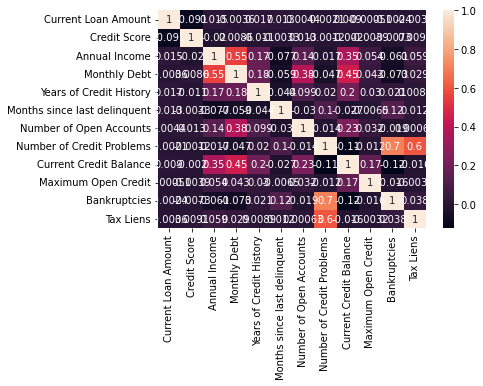

In [158]:
sns.heatmap(pdf.corr(), annot=True)
plt.show()

### Ranking of the most significant predictor variables

From the **`DRF`** model, below is the ranked table from most significant to least significant predictor variables

Predictor with importance less than 9% is excluded from the model hereonwards Ex. `Term` 3.3%, `Number of Credit Problems` 2.8% and `Tax Liens` 1.24% etc.

**scaled_importance** column indicates the % of importance for individual predictors

In [159]:
variableIMP = best.varimp(use_pandas=True)
#Converting values into % for scaled_importance column
variableIMP.scaled_importance=variableIMP.scaled_importance*100
#Getting rid of insignificant predictors
highIMP = variableIMP.where(variableIMP.scaled_importance > 9)
highIMP = highIMP.dropna()
highIMP

,variable,relative_importance,scaled_importance,percentage
0,Credit Score,44759.878906,100.000000,0.369561
1,Current Loan Amount,12418.345703,27.744368,0.102532
2,Years in current job,8296.091797,18.534661,0.068497
3,Annual Income,7722.340332,17.252818,0.063760
4,Years of Credit History,7420.987793,16.579553,0.061272
5,Months since last delinquent,7333.394043,16.383856,0.060548
6,Monthly Debt,7235.675293,16.165538,0.059741
7,Number of Open Accounts,6172.034180,13.789211,0.050960
8,Current Credit Balance,5495.642090,12.278054,0.045375
9,Purpose,4258.420410,9.513923,0.035160


### Does the model make sense ?

As we can see in below performance metrics, The `DRF` model has performed better than other models from leaderboard

As AUC (**81.4%**) is highest and MSE (**0.11**), RMSE (**0.33**) and LogLoss (**0.36**) are lesser among all other model. 

Also, from cross validation summary we can see that apart from AUC and MSE the Precision (**83%**), Recall (**99.7%**) and F1_Score (**91.18%**) which seems good as F1 score tells about the balance between Precision and Recall values

DRF prevents overfitting by creating a forest of classification trees but one drawback of it settles up with accuracy and after certain level it often doesn't increase anymore.

However, There is a scope for improvement this `DRF` model and we can increase the accuracy by tuning few hyperparameters such as `No.of Trees`, `Max Depth` as well as improve Precision and Recall value of H2ORandomForestEstimator.

In [160]:
mod_perf = best.model_performance(df_test)
stats_test = {}
stats_test = model_performance_stats(mod_perf)
stats_test

{'mse': 0.11438375424067015,
 'rmse': 0.3382066738558986,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None,
 'logloss': 0.3634367523650762,
 'auc': 0.8141908689530367,
 'gini': 0.6283817379060734}

In [162]:
best.cross_validation_metrics_summary()


Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.846812,0.002333,0.844324,0.845800,0.848589,0.849902,0.845447
1,auc,0.806924,0.003644,0.809226,0.806962,0.805706,0.811143,0.801581
2,err,0.153187,0.002333,0.155676,0.154199,0.151411,0.150098,0.154553
3,err_count,933.800000,14.202112,949.000000,940.000000,923.000000,915.000000,942.000000
4,f0point5,0.866246,0.002092,0.863679,0.865340,0.867840,0.868888,0.865484
5,f1,0.911859,0.001445,0.910209,0.911103,0.912834,0.913817,0.911333
6,f2,0.962544,0.000688,0.962038,0.961976,0.962749,0.963647,0.962311
7,lift_top_group,1.261456,0.004389,1.267360,1.264468,1.260285,1.256648,1.258517
8,logloss,0.368789,0.004080,0.371496,0.370264,0.367616,0.362227,0.372344
9,max_per_class_error,0.737550,0.007939,0.737947,0.734118,0.729944,0.734940,0.750799


### Preparing Model To Re-Train


In [69]:
og_df=og_df.na_omit()
og_pdf = og_pdf.dropna()
newdf = og_df
newpdf = og_pdf

### Which Independent Variables Are Significant ?

As we saw earlier, there are few insignificant predictors in the data
So, Removing them from data and keeping other significant predictors only as shown below

In [181]:
highIMP

,variable,relative_importance,scaled_importance,percentage
0,Credit Score,44759.878906,100.000000,0.369561
1,Current Loan Amount,12418.345703,27.744368,0.102532
2,Years in current job,8296.091797,18.534661,0.068497
3,Annual Income,7722.340332,17.252818,0.063760
4,Years of Credit History,7420.987793,16.579553,0.061272
5,Months since last delinquent,7333.394043,16.383856,0.060548
6,Monthly Debt,7235.675293,16.165538,0.059741
7,Number of Open Accounts,6172.034180,13.789211,0.050960
8,Current Credit Balance,5495.642090,12.278054,0.045375
9,Purpose,4258.420410,9.513923,0.035160


In [70]:
# Remvoing constant/bad columns
newdf=newdf.drop('Loan ID')
newdf=newdf.drop('Customer ID')

#Removing insignificant predictors
newdf=newdf.drop('Tax Liens')
newdf=newdf.drop('Bankruptcies')
newdf=newdf.drop('Number of Credit Problems')
newdf=newdf.drop('Term')
newdf=newdf.drop('Home Ownership')
print("Done")

Done


In [14]:
# Create a 80/20 train/test splie
pct_rows=0.80
newdf_train, newdf_test = newdf.split_frame([pct_rows])
print("Training: ",newdf_train.shape)
print("Validation: ",newdf_test.shape)

# Set target and predictor variables
X=newdf.columns
target ='Loan Status'
X.remove(target)
newdf_train[target]=newdf_train[target].asfactor()
newdf_test[target]=newdf_test[target].asfactor()
print("Predictors: \n",X)

Training:  (30246, 12)
Validation:  (7764, 12)
Predictors: 
 ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Years in current job', 'Purpose', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit']


In [129]:
# # Set up AutoML

# include_algos = ["DRF"]
# newaml = H2OAutoML(nfolds=0,seed=1,max_runtime_secs=run_time,include_algos=include_algos)


In [132]:
# weights_column = "Credit Score"
# validation_frame = newdf_test
# newaml.train(x=X,y=target,training_frame=newdf_train,validation_frame=validation_frame)


In [133]:
# newaml.leaderboard

### Which Hyperparameters Are Important ?

To improve the accuracy of the Random Forest, We will be tuning hyper `Number of Trees` as 70 and `Max_Depth` as 25 in order to Pre-Prune the tree so that it stops the growth of the tree to avoid overfitting

Also, We will be setting `Number of Folds` as 5, which is K-fold cross validation and will be then used for bootstraping and then bagging

In [15]:

drf = H2ORandomForestEstimator(ntrees=70,
                                max_depth=25,
                                validation_frame=newdf_test,
                                nfolds=5
                                )

In [60]:
drf.train(x=X,
            y=target,
            training_frame=newdf_train,
            validation_frame=newdf_test,
            max_runtime_secs=run_time
            )

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1644735901562_4139


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,70.0,70.0,2784521.0,25.0,25.0,25.0,2763.0,3392.0,3157.6428




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11550712757522018
RMSE: 0.33986339546238303
LogLoss: 0.3716674286486256
Mean Per-Class Error: 0.3667427267121362
AUC: 0.8106717041261602
AUCPR: 0.9403452054397984
Gini: 0.6213434082523204

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39944684734248154: 


,,Charged Off,Fully Paid,Error,Rate
0,Charged Off,1677.0,4594.0,0.7326,(4594.0/6271.0)
1,Fully Paid,22.0,24236.0,0.0009,(22.0/24258.0)
2,Total,1699.0,28830.0,0.1512,(4616.0/30529.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.399447,0.913050,356.0
1,max f2,0.276978,0.963269,368.0
2,max f0point5,0.703661,0.873560,236.0
3,max accuracy,0.399447,0.848800,356.0
4,max precision,0.999999,0.998233,0.0
5,max recall,0.276978,1.000000,368.0
6,max specificity,0.999999,0.998884,0.0
7,max absolute_mcc,0.399447,0.469675,356.0
8,max min_per_class_accuracy,0.805470,0.719502,161.0
9,max mean_per_class_accuracy,0.806579,0.720319,160.0



Gains/Lift Table: Avg response rate: 79.46 %, avg score: 80.02 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.129582,1.000000,1.256286,1.256286,0.998231,1.000000,0.998231,1.000000,0.162792,0.162792,25.628576,25.628576,0.161675
1,2,0.150021,0.985412,1.220193,1.251368,0.969551,0.992682,0.994323,0.999003,0.024940,0.187732,22.019256,25.136826,0.183586
2,3,0.201874,0.958333,1.210812,1.240951,0.962097,0.967646,0.986046,0.990949,0.062783,0.250515,21.081161,24.095106,0.236801
3,4,0.300010,0.922910,1.171559,1.218252,0.930908,0.941270,0.968010,0.974698,0.114972,0.365488,17.155934,21.825234,0.318765
4,5,0.401553,0.888889,1.134285,1.197019,0.901290,0.905811,0.951138,0.957279,0.115178,0.480666,13.428528,19.701913,0.385147
5,6,0.500016,0.855648,1.075974,1.173183,0.854957,0.872185,0.932198,0.940522,0.105944,0.586611,7.597389,17.318278,0.421565
6,7,0.599987,0.816991,1.035840,1.150299,0.823067,0.836445,0.914014,0.923180,0.103553,0.690164,3.584004,15.029857,0.439008
7,8,0.699990,0.773368,0.971194,1.124711,0.771700,0.795598,0.893683,0.904953,0.097123,0.787287,-2.880582,12.471103,0.424984
8,9,0.800419,0.714286,0.904684,1.097104,0.718852,0.745191,0.871747,0.884908,0.090857,0.878143,-9.531576,9.710413,0.378382
9,10,0.900226,0.608696,0.864892,1.071359,0.687233,0.668694,0.851290,0.860937,0.086322,0.964465,-13.510814,7.135910,0.312735




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.11714081742000877
RMSE: 0.34225840737666147
LogLoss: 0.36626236370849596
Mean Per-Class Error: 0.3631661790323566
AUC: 0.8250244343757965
AUCPR: 0.9427351669093961
Gini: 0.6500488687515931

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.492500357649156: 


,,Charged Off,Fully Paid,Error,Rate
0,Charged Off,445.0,1175.0,0.7253,(1175.0/1620.0)
1,Fully Paid,6.0,5855.0,0.001,(6.0/5861.0)
2,Total,451.0,7030.0,0.1579,(1181.0/7481.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.492500,0.908386,380.0
1,max f2,0.426144,0.960977,389.0
2,max f0point5,0.753181,0.873780,241.0
3,max accuracy,0.584028,0.842802,350.0
4,max precision,0.999999,1.000000,0.0
5,max recall,0.426144,1.000000,389.0
6,max specificity,0.999999,1.000000,0.0
7,max absolute_mcc,0.492500,0.473588,380.0
8,max min_per_class_accuracy,0.805536,0.724074,191.0
9,max mean_per_class_accuracy,0.835934,0.733720,160.0



Gains/Lift Table: Avg response rate: 78.35 %, avg score: 79.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.097848,1.000000,1.276403,1.276403,1.000000,1.000000,1.000000,1.000000,0.124893,0.124893,27.640334,27.640334,0.124893
1,2,0.100120,0.997224,1.276403,1.276403,1.000000,0.998799,1.000000,0.999973,0.002901,0.127794,27.640334,27.640334,0.127794
2,3,0.150114,0.966633,1.272991,1.275267,0.997326,0.980113,0.999110,0.993359,0.063641,0.191435,27.299050,27.526674,0.190818
3,4,0.200107,0.941912,1.235449,1.265319,0.967914,0.952681,0.991316,0.983196,0.061764,0.253199,23.544923,26.531901,0.245174
4,5,0.300094,0.910486,1.192789,1.241153,0.934492,0.925295,0.972383,0.963904,0.119263,0.372462,19.278869,24.115301,0.334190
5,6,0.400080,0.880508,1.150128,1.218404,0.901070,0.895115,0.954561,0.946713,0.114997,0.487459,15.012815,21.840439,0.403509
6,7,0.500067,0.850476,1.102348,1.195199,0.863636,0.865007,0.936381,0.930376,0.110220,0.597680,10.234834,19.519939,0.450766
7,8,0.602059,0.814286,0.995360,1.161346,0.779817,0.832761,0.909858,0.913839,0.101519,0.699198,-0.463959,16.134567,0.448581
8,9,0.700040,0.775166,0.997789,1.138453,0.781719,0.795224,0.891923,0.897237,0.097765,0.796963,-0.221130,13.845332,0.447580
9,10,0.800027,0.721505,0.899284,1.108562,0.704545,0.749344,0.868505,0.878754,0.089916,0.886879,-10.071583,10.856217,0.401077




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.11502831920982826
RMSE: 0.3391582509829715
LogLoss: 0.36254623002531466
Mean Per-Class Error: 0.36810520953331655
AUC: 0.8120607774614044
AUCPR: 0.941889790167519
Gini: 0.6241215549228087

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41991793970976554: 


,,Charged Off,Fully Paid,Error,Rate
0,Charged Off,1655.0,4616.0,0.7361,(4616.0/6271.0)
1,Fully Paid,3.0,24255.0,0.0001,(3.0/24258.0)
2,Total,1658.0,28871.0,0.1513,(4619.0/30529.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.419918,0.913061,382.0
1,max f2,0.392127,0.963292,385.0
2,max f0point5,0.708950,0.874178,265.0
3,max accuracy,0.428171,0.848701,381.0
4,max precision,0.999999,1.000000,0.0
5,max recall,0.392127,1.000000,385.0
6,max specificity,0.999999,1.000000,0.0
7,max absolute_mcc,0.419918,0.470252,382.0
8,max min_per_class_accuracy,0.801318,0.715558,183.0
9,max mean_per_class_accuracy,0.813574,0.717557,171.0



Gains/Lift Table: Avg response rate: 79.46 %, avg score: 79.77 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.098497,1.000000,1.258513,1.258513,1.000000,1.000000,1.000000,1.000000,0.123959,0.123959,25.851266,25.851266,0.123959
1,2,0.100003,0.995970,1.258513,1.258513,1.000000,0.998290,1.000000,0.999974,0.001896,0.125855,25.851266,25.851266,0.125855
2,3,0.150021,0.969230,1.254392,1.257139,0.996726,0.981275,0.998908,0.993740,0.062742,0.188598,25.439179,25.713873,0.187800
3,4,0.201087,0.942857,1.214921,1.246417,0.965362,0.954634,0.990389,0.983809,0.062041,0.250639,21.492081,24.641749,0.241231
4,5,0.300010,0.908506,1.178918,1.224161,0.936755,0.924492,0.972704,0.964250,0.116621,0.367260,17.891798,22.416085,0.327394
5,6,0.400013,0.877551,1.128251,1.200183,0.896495,0.892784,0.953652,0.946384,0.112829,0.480089,12.825062,20.018329,0.389832
6,7,0.500016,0.844776,1.064356,1.173018,0.845726,0.860748,0.932067,0.929256,0.106439,0.586528,6.435626,17.301789,0.421164
7,8,0.599987,0.811522,1.028005,1.148856,0.816841,0.828631,0.912868,0.912490,0.102770,0.689298,2.800526,14.885571,0.434794
8,9,0.699990,0.771927,0.967896,1.123003,0.769080,0.792456,0.892326,0.895342,0.096793,0.786091,-3.210360,12.300317,0.419164
9,10,0.800026,0.724286,0.923074,1.098004,0.733464,0.749549,0.872462,0.877112,0.092341,0.878432,-7.692588,9.800386,0.381701




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.848938,0.002557,0.848339,0.845617,0.848643,0.849342,0.852748
1,auc,0.812036,0.004477,0.813042,0.810190,0.818893,0.806722,0.811333
2,err,0.151062,0.002557,0.151661,0.154383,0.151357,0.150658,0.147252
3,err_count,922.400000,20.562101,913.000000,951.000000,926.000000,927.000000,895.000000
4,f0point5,0.868179,0.002603,0.867960,0.864742,0.867732,0.868408,0.872051
5,f1,0.913142,0.001859,0.912321,0.910947,0.912954,0.913486,0.916002
6,f2,0.963019,0.001189,0.961461,0.962368,0.963148,0.963500,0.964618
7,lift_top_group,1.258546,0.008131,1.263909,1.266447,1.259625,1.257254,1.245492
8,logloss,0.362535,0.004042,0.364012,0.367184,0.359750,0.364622,0.357108
9,max_per_class_error,0.733342,0.011166,0.715990,0.733796,0.733545,0.736299,0.747078



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-02-13 02:18:03,26.049 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-02-13 02:18:03,26.109 sec,1.0,0.462387,6.930911,0.655022,0.849787,1.074707,0.209219,0.468357,7.101750,0.653484,0.843623,1.082422,0.216549
2,,2022-02-13 02:18:03,26.154 sec,2.0,0.453214,6.241685,0.661313,0.852075,1.077686,0.209393,0.405171,3.365930,0.702033,0.864101,1.111141,0.167224
3,,2022-02-13 02:18:03,26.197 sec,3.0,0.439530,5.417298,0.672571,0.856736,1.083998,0.209288,0.384009,2.159875,0.727782,0.878867,1.138404,0.161877
4,,2022-02-13 02:18:03,26.242 sec,4.0,0.427307,4.740641,0.684246,0.863718,1.093723,0.186742,0.375654,1.707099,0.737316,0.885489,1.152907,0.161743
5,,2022-02-13 02:18:03,26.301 sec,5.0,0.415775,4.096651,0.694001,0.868415,1.100426,0.177970,0.369443,1.351693,0.749217,0.893675,1.170963,0.160674
6,,2022-02-13 02:18:03,26.357 sec,6.0,0.407421,3.601787,0.702026,0.872176,1.106324,0.172366,0.364362,1.107384,0.758265,0.900116,1.186019,0.160406
7,,2022-02-13 02:18:03,26.415 sec,7.0,0.399354,3.170591,0.708944,0.875389,1.111614,0.168472,0.361488,0.937552,0.764794,0.905149,1.198839,0.159872
8,,2022-02-13 02:18:03,26.477 sec,8.0,0.391670,2.761520,0.717023,0.879379,1.118264,0.163992,0.359059,0.798872,0.771276,0.909955,1.211395,0.159872
9,,2022-02-13 02:18:03,26.549 sec,9.0,0.384902,2.402429,0.724618,0.883526,1.125499,0.160657,0.357275,0.711789,0.774619,0.912891,1.220306,0.159604



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Credit Score,70757.976562,1.000000,0.333247
1,Current Loan Amount,21669.292969,0.306245,0.102055
2,Annual Income,15938.094727,0.225248,0.075063
3,Monthly Debt,15476.867188,0.218730,0.072891
4,Years of Credit History,15450.063477,0.218351,0.072765
5,Months since last delinquent,15197.212891,0.214777,0.071574
6,Years in current job,14701.419922,0.207770,0.069239
7,Number of Open Accounts,12684.539062,0.179267,0.059740
8,Current Credit Balance,12659.173828,0.178908,0.059621
9,Maximum Open Credit,10477.102539,0.148070,0.049344


### Does regularization helps ?

As we tuned hyperparameters, as a result we can see there is slight increase in `AUC` to **82.50%** from base model's 81%. Also, `MSE` and `RMSE` are slightly lesser than base model which denotes that tuning hyperparamter has made model better than base model

As this is `DRF` eventually there is not much increase in accuracy in decision tree classifiers which is also one of draw back of such classification model

Other performance metrics such as `LogLoss`, and `Classification Error` can be seen in graphs shown below which indicates as `Number of Trees` increased `Classification Error` decreased and settled after 20 Trees

In [61]:
mod_perf = drf.model_performance(newdf_test)
stats_test = {}
stats_test = model_performance_stats(mod_perf)
stats_test

{'mse': 0.11714081742000877,
 'rmse': 0.34225840737666147,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None,
 'logloss': 0.36626236370849596,
 'auc': 0.8250244343757965,
 'gini': 0.6500488687515931}

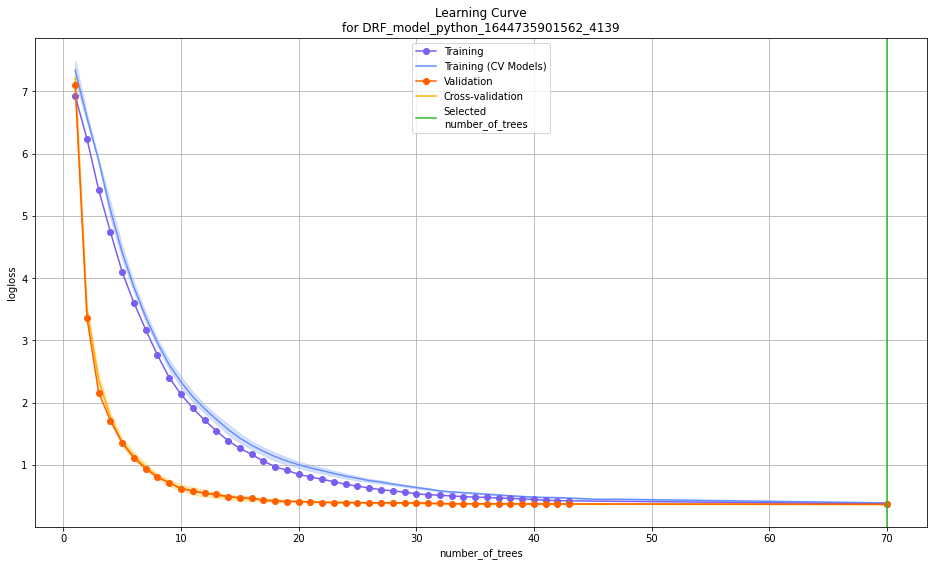

In [62]:
drf.learning_curve_plot()

In [63]:
drf.accuracy()

[[0.39944684734248154, 0.8487995021127452]]

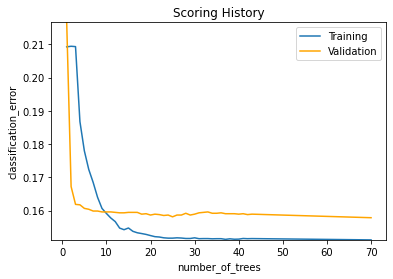

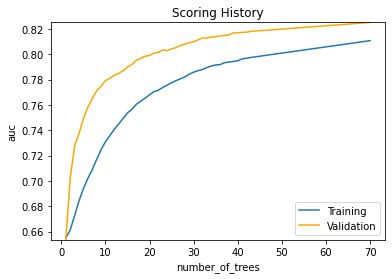

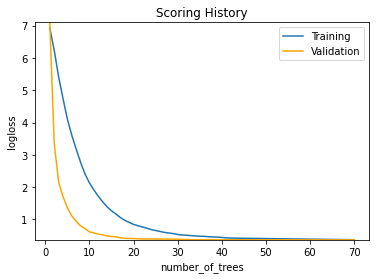

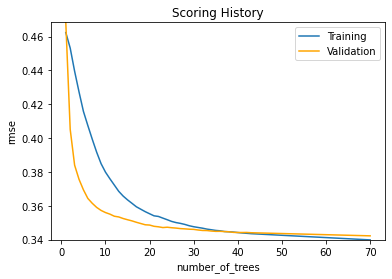

In [64]:
drf.plot(metric='classification_error')
drf.plot(metric='auc')
drf.plot(metric='logloss')
drf.plot(metric='rmse')


In [76]:
# import statsmodels.formula.api as smf 
# ols_result = smf.ols('Loan_Status ~ Credit_Score + Current_Loan_Amount  + Annual_Income + Years_of_Credit_History + Months_since_last_delinquent +  Monthly_Debt + Number_of_Open_Accounts + Current_Credit_Balance  + Maximum_Open_Credit',data = newpdf).fit()


In [ ]:
# ols_result.summary()